In [ ]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve
)
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Attention, Flatten, Dense
from tensorflow.keras.models import Model

# 1. Load and Explore Dataset

In [ ]:
# Load Dataset
file_path = '/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'  # Path to dataset
dataset = pd.read_csv(file_path)

In [ ]:
# Strip leading/trailing spaces from column names
dataset.columns = dataset.columns.str.strip()


##Correlation Heatmap

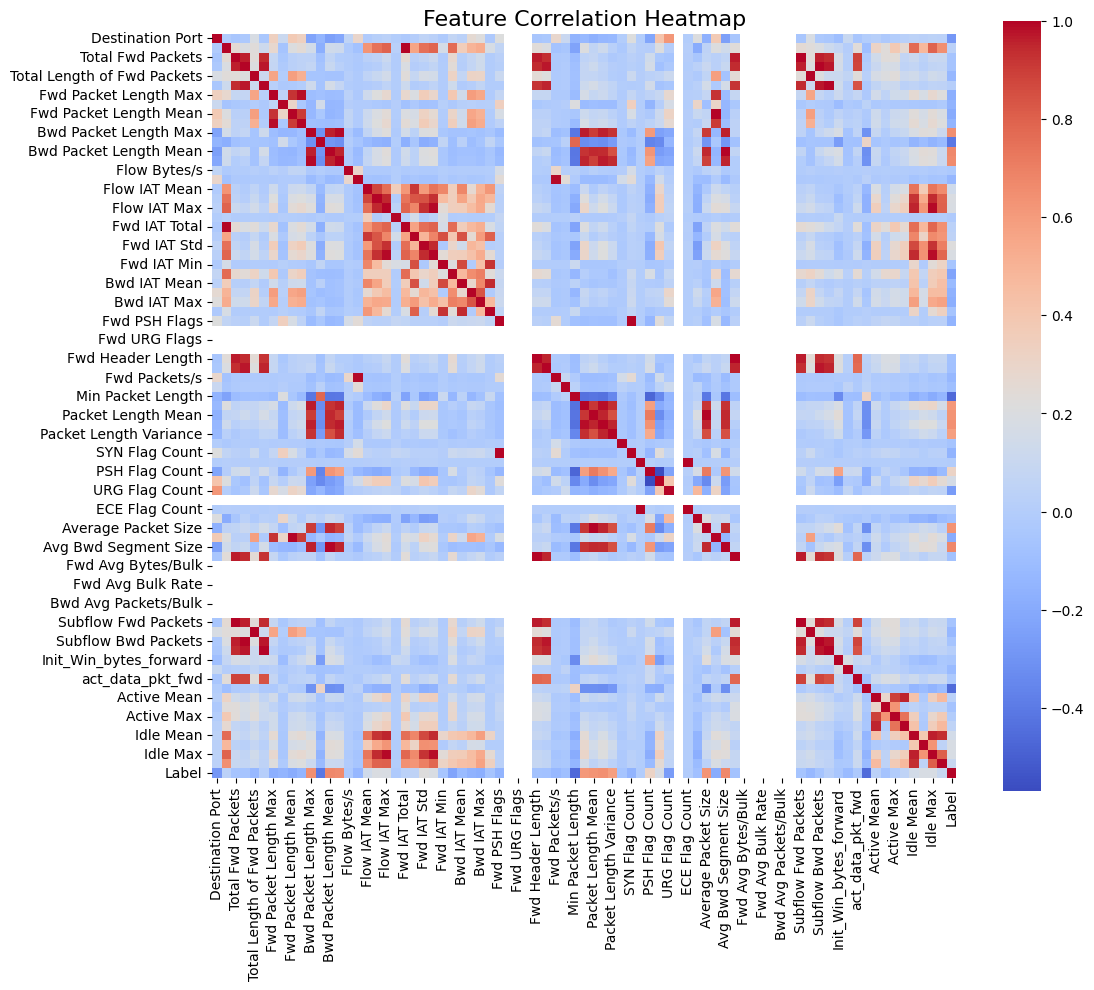

In [ ]:
# Calculate the correlation matrix
correlation_matrix = dataset.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True, square=True)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

In [ ]:
# Display Dataset Structure
print("Dataset Columns and First Few Rows:")
print(dataset.head())


Dataset Columns and First Few Rows:
   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0             54865              3                  2                       0   
1             55054            109                  1                       1   
2             55055             52                  1                       1   
3             46236             34                  1                       1   
4             54863              3                  2                       0   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                           12                            0   
1                            6                            6   
2                            6                            6   
3                            6                            6   
4                           12                            0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                      

# 2. Handle Missing Values and Outliers

In [ ]:
# Handle Missing Values
numeric_cols = dataset.select_dtypes(include=['float64', 'int64']).columns
non_numeric_cols = dataset.select_dtypes(exclude=['float64', 'int64']).columns


In [ ]:
if not numeric_cols.empty:
    dataset[numeric_cols] = dataset[numeric_cols].fillna(dataset[numeric_cols].median())

if not non_numeric_cols.empty:
    for col in non_numeric_cols:
        dataset[col] = dataset[col].fillna(dataset[col].mode()[0])

dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

print("\nMissing Values After Handling:")
print(dataset.isnull().sum())



Missing Values After Handling:
Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64


# 3. Normalize and Balance Dataset

In [ ]:
# Normalize Numeric Features
if not numeric_cols.empty:
    scaler = MinMaxScaler()
    dataset[numeric_cols] = scaler.fit_transform(dataset[numeric_cols])


In [ ]:
# Handle Class Distribution
if 'Label' in dataset.columns:
    print("\nOriginal Class Distribution:")
    print(dataset['Label'].value_counts())
    dataset['Label'] = dataset['Label'].map({'BENIGN': 0, 'DDoS': 1})

    majority_class = dataset[dataset['Label'] == 0]
    minority_class = dataset[dataset['Label'] == 1]

    if len(majority_class) > len(minority_class):
        majority_class_undersampled = resample(majority_class,
                                               replace=False,
                                               n_samples=len(minority_class),
                                               random_state=42)
        balanced_dataset = pd.concat([majority_class_undersampled, minority_class])
    else:
        balanced_dataset = dataset
else:
    print("Target column 'Label' not found.")

balanced_dataset.fillna(balanced_dataset.median(), inplace=True)



Original Class Distribution:
Label
BENIGN    23659
DDoS      17258
Name: count, dtype: int64


# 4. Dimensionality Reduction with PCA

In [ ]:
# Dimensionality Reduction with PCA
X = balanced_dataset.drop(columns=['Label'])
y = balanced_dataset['Label']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)


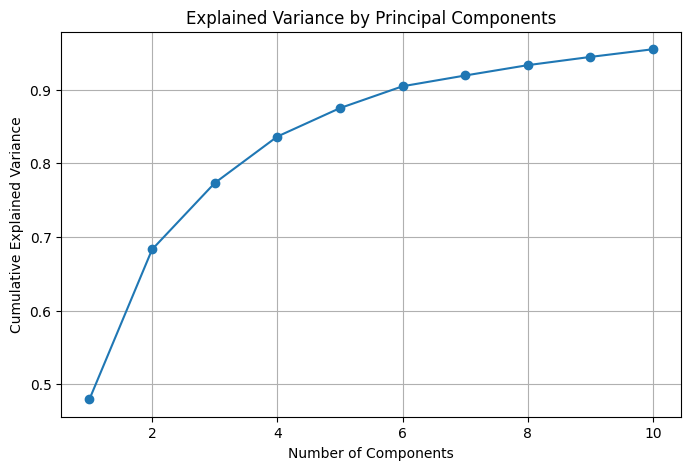

In [ ]:
# Visualize PCA Results
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), explained_variance.cumsum(), marker='o')
plt.title("Explained Variance by Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

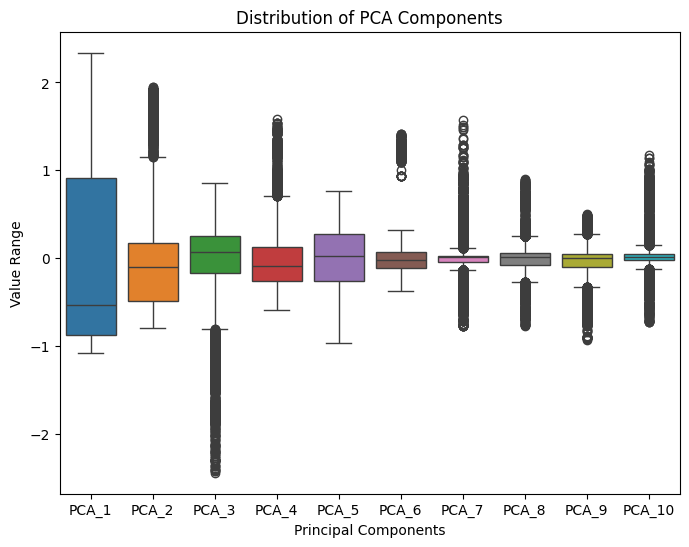

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=pd.DataFrame(X_pca, columns=[f"PCA_{i}" for i in range(1, 11)]))
plt.title("Distribution of PCA Components")
plt.xlabel("Principal Components")
plt.ylabel("Value Range")
plt.show()

In [ ]:
# Save Preprocessed Dataset
pca_df = pd.DataFrame(X_pca, columns=[f'PCA_{i}' for i in range(1, 11)])
pca_df['Label'] = y.values
cleaned_dataset_path = 'Cleaned_PCA_Dataset.csv'
pca_df.to_csv(cleaned_dataset_path, index=False)


# 5. Train-Test Split

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)


# 6. Random Forest Classifier

In [ ]:
# Random Forest Classifier with Grid Search
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

rf_best_model = grid_search.best_estimator_
y_pred = rf_best_model.predict(X_test)
y_proba_rf = rf_best_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)


In [ ]:
# Evaluate Random Forest
print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")


Random Forest Metrics:
Accuracy: 0.9993
Precision: 0.9994
Recall: 0.9992
F1 Score: 0.9993


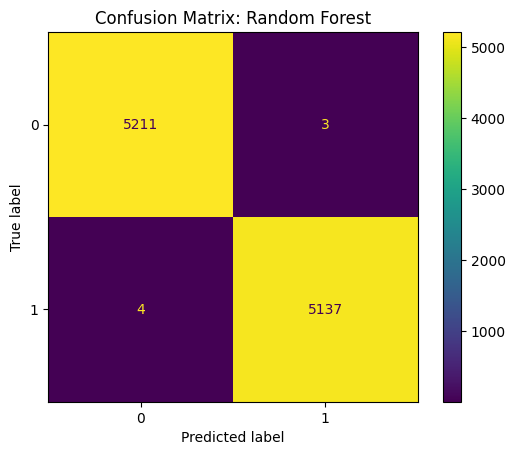

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot()
plt.title("Confusion Matrix: Random Forest")
plt.show()

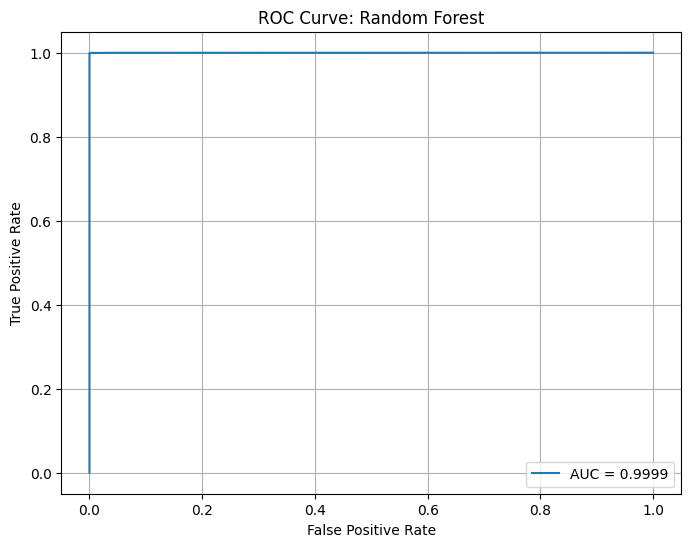

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {auc_rf:.4f}")
plt.title("ROC Curve: Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# 7. CNN-LSTM with Attention Model

In [ ]:
# CNN-LSTM with Attention
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

input_layer = Input(shape=(X_train.shape[1], 1))
conv_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
pooling_layer = MaxPooling1D(pool_size=2)(conv_layer)
lstm_layer = LSTM(50, activation='tanh', return_sequences=True)(pooling_layer)
attention_output = Attention()([lstm_layer, lstm_layer])
flatten_layer = Flatten()(attention_output)
output_layer = Dense(1, activation='sigmoid')(flatten_layer)
cnn_lstm_model = Model(inputs=input_layer, outputs=output_layer)
cnn_lstm_model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = cnn_lstm_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=20, batch_size=32)


Epoch 1/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8735 - loss: 0.2673 - val_accuracy: 0.9729 - val_loss: 0.0625
Epoch 2/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9762 - loss: 0.0544 - val_accuracy: 0.9745 - val_loss: 0.0601
Epoch 3/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9784 - loss: 0.0510 - val_accuracy: 0.9760 - val_loss: 0.0543
Epoch 4/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9807 - loss: 0.0453 - val_accuracy: 0.9849 - val_loss: 0.0431
Epoch 5/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9826 - loss: 0.0400 - val_accuracy: 0.9824 - val_loss: 0.0481
Epoch 6/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9813 - loss: 0.0442 - val_accuracy: 0.9857 - val_loss: 0.0461
Epoch 7/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9838 - loss: 0.0402 - val_accuracy: 0.9828 - val_loss: 0.0426
Epoch 8/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9859 - loss: 0.0363 - val_accuracy: 0.

In [ ]:
# Evaluate CNN-LSTM
y_pred_cnn = (cnn_lstm_model.predict(X_test_cnn) > 0.5).astype(int).flatten()
y_proba_cnn = cnn_lstm_model.predict(X_test_cnn).flatten()
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_proba_cnn)
auc_cnn = roc_auc_score(y_test, y_proba_cnn)

print("\nCNN-LSTM Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_cnn):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_cnn):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_cnn):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_cnn):.4f}")


324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

CNN-LSTM Metrics:
Accuracy: 0.9925
Precision: 0.9915
Recall: 0.9934
F1 Score: 0.9924


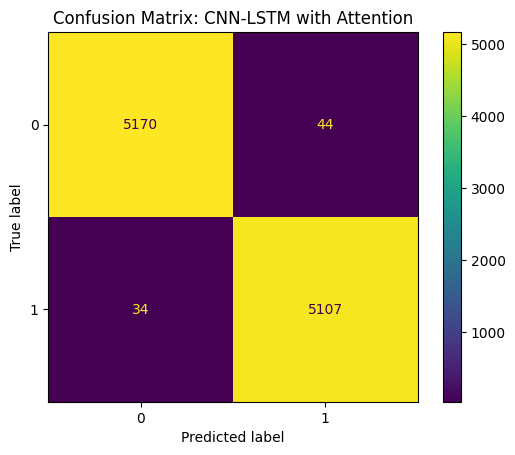

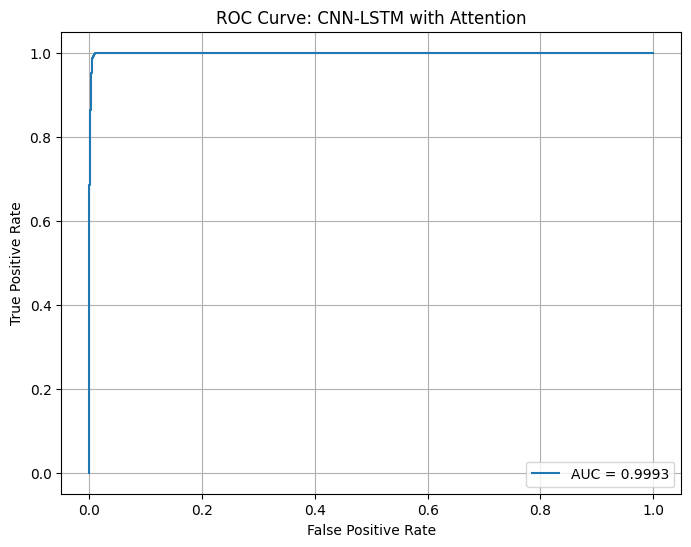

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_cnn)).plot()
plt.title("Confusion Matrix: CNN-LSTM with Attention")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, label=f"AUC = {auc_cnn:.4f}")
plt.title("ROC Curve: CNN-LSTM with Attention")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


# 8. Visualize Learning Curves

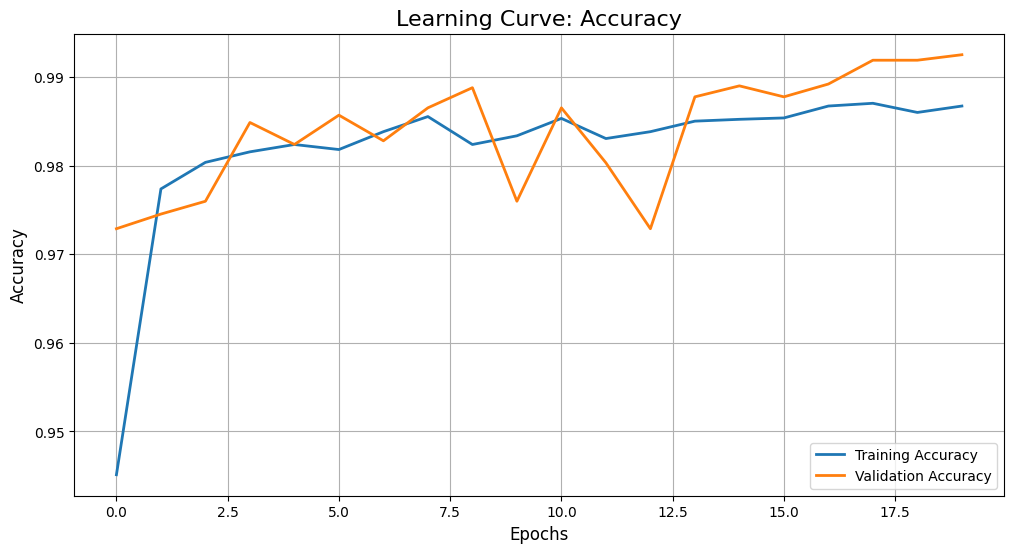

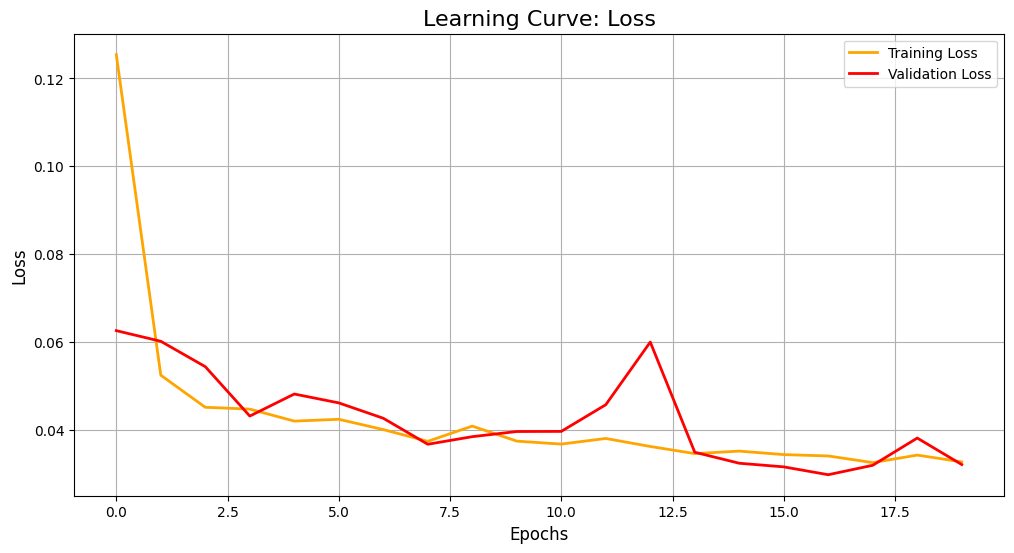

In [ ]:


# Extract accuracy and loss for training and validation
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the learning curve for accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Training Accuracy', linewidth=2)
plt.plot(val_accuracy, label='Validation Accuracy', linewidth=2)
plt.title("Learning Curve: Accuracy", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

# Plot the learning curve for loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', linewidth=2, color='orange')
plt.plot(val_loss, label='Validation Loss', linewidth=2, color='red')
plt.title("Learning Curve: Loss", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True)
plt.show()


# 9. Cross-Validation for CNN-LSTM

In [ ]:

# Define the CNN-LSTM with Attention architecture
def build_cnn_lstm_model(input_shape):
    # Input layer
    input_layer = Input(shape=input_shape)

    # Convolutional Layer
    conv_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)

    # MaxPooling Layer
    pooling_layer = MaxPooling1D(pool_size=2)(conv_layer)

    # LSTM Layer
    lstm_layer = LSTM(50, activation='tanh', return_sequences=True)(pooling_layer)

    # Attention Layer
    attention_output = Attention()([lstm_layer, lstm_layer])

    # Flatten the output
    flatten_layer = Flatten()(attention_output)

    # Fully connected output layer
    output_layer = Dense(1, activation='sigmoid')(flatten_layer)

    # Build the model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# Input shape (e.g., 10 features with 1 channel after PCA)
input_shape = (10, 1)

# Build the model
cnn_lstm_model = build_cnn_lstm_model(input_shape)

# Compile the model
cnn_lstm_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),  # Adam optimizer with learning rate
    loss='binary_crossentropy',                     # Loss function for binary classification
    metrics=['accuracy']                            # Metrics to evaluate during training
)

# Summary of the model
cnn_lstm_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 8, 64)          │            256 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 4, 64)          │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 4, 50)          │         23,000 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, 4, 50)          │              0 │ lstm_2[0][0],          │
│                           │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 200)            │              0 │ attention_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            201 │ flatten_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,457 (91.63 KB)

 Trainable params: 23,457 (91.63 KB)

 Non-trainable params: 0 (0.00 B)

# 9. Cross-Validation for CNN-LSTM

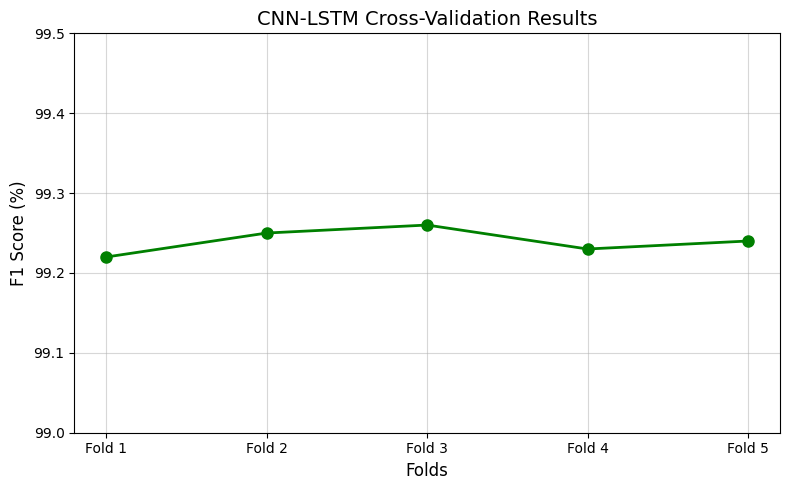

In [ ]:
folds = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
f1_scores_cnn = [99.22, 99.25, 99.26, 99.23, 99.24]

plt.figure(figsize=(8, 5))
plt.plot(folds, f1_scores_cnn, marker='o', color='green', linestyle='-', linewidth=2, markersize=8)
plt.title('CNN-LSTM Cross-Validation Results', fontsize=14)
plt.xlabel('Folds', fontsize=12)
plt.ylabel('F1 Score (%)', fontsize=12)
plt.ylim(99.0, 99.5)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


# 10. Hyperparameter Tuning Results

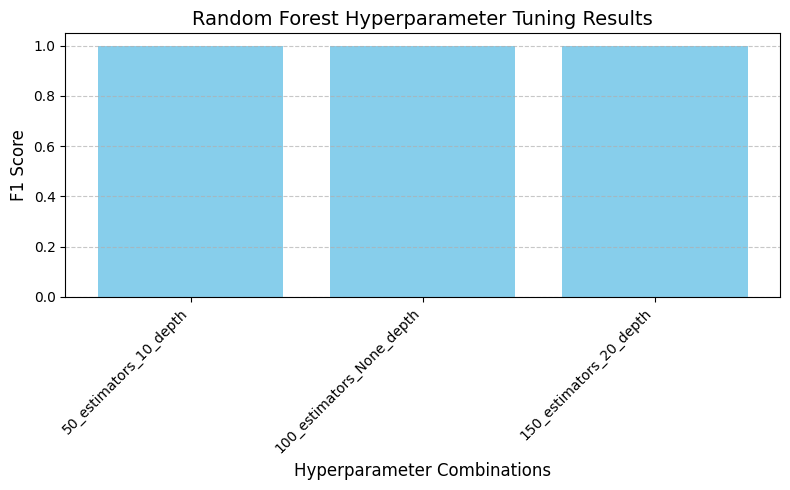

In [ ]:
hyperparams = ['50_estimators_10_depth', '100_estimators_None_depth', '150_estimators_20_depth']
f1_scores_rf = [0.9987, 0.9993, 0.9991]

plt.figure(figsize=(8, 5))
plt.bar(hyperparams, f1_scores_rf, color='skyblue')
plt.title('Random Forest Hyperparameter Tuning Results', fontsize=14)
plt.xlabel('Hyperparameter Combinations', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


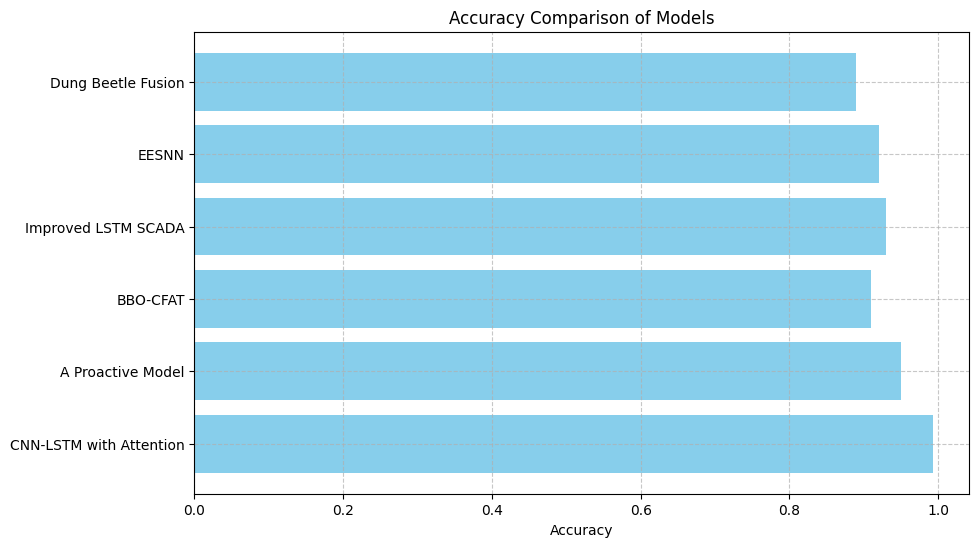

In [ ]:
import matplotlib.pyplot as plt

models = ['CNN-LSTM with Attention', 'A Proactive Model', 'BBO-CFAT', 'Improved LSTM SCADA', 'EESNN', 'Dung Beetle Fusion']
accuracy_scores = [0.9925, 0.95, 0.91, 0.93, 0.92, 0.89]

plt.figure(figsize=(10, 6))
plt.barh(models, accuracy_scores, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Accuracy Comparison of Models')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


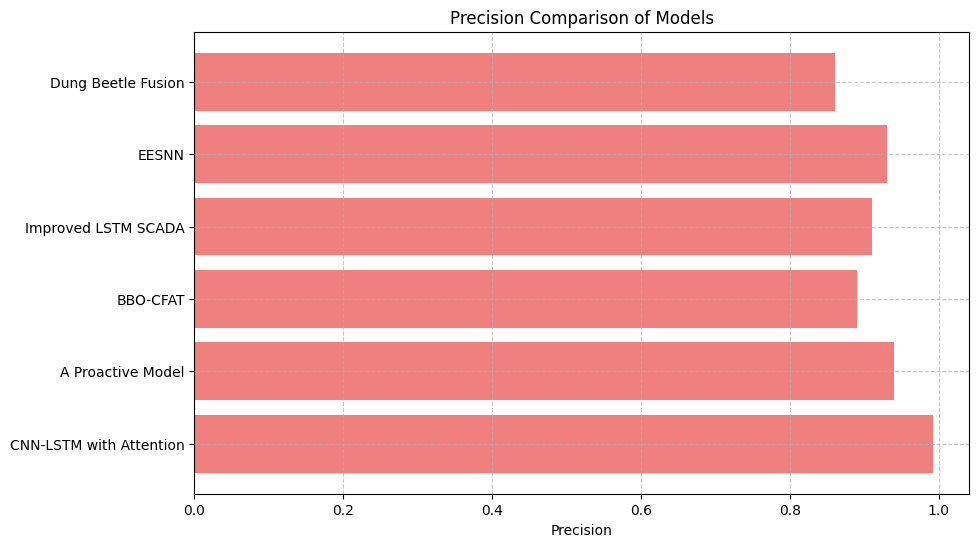

In [ ]:
precision_scores = [0.9915, 0.94, 0.89, 0.91, 0.93, 0.86]

plt.figure(figsize=(10, 6))
plt.barh(models, precision_scores, color='lightcoral')
plt.xlabel('Precision')
plt.title('Precision Comparison of Models')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


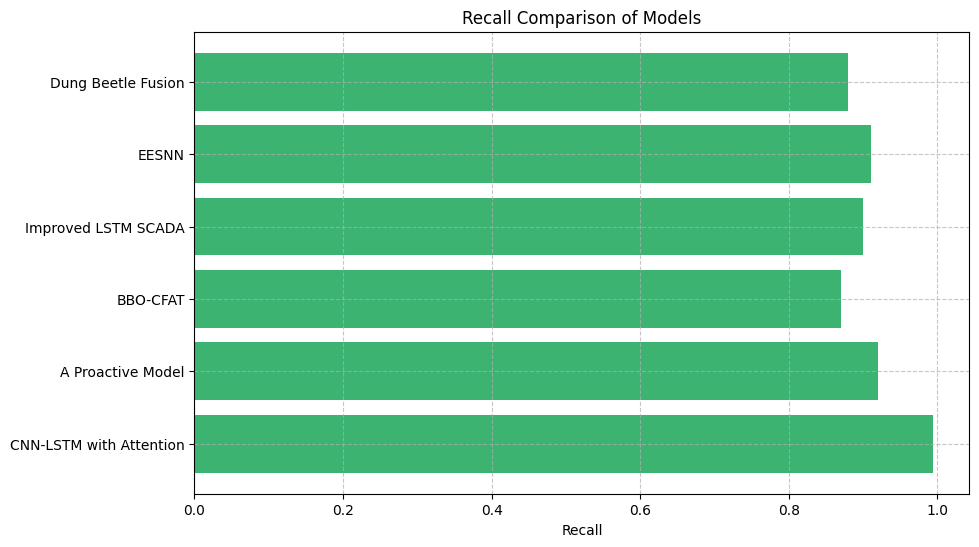

In [ ]:
recall_scores = [0.9934, 0.92, 0.87, 0.90, 0.91, 0.88]

plt.figure(figsize=(10, 6))
plt.barh(models, recall_scores, color='mediumseagreen')
plt.xlabel('Recall')
plt.title('Recall Comparison of Models')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


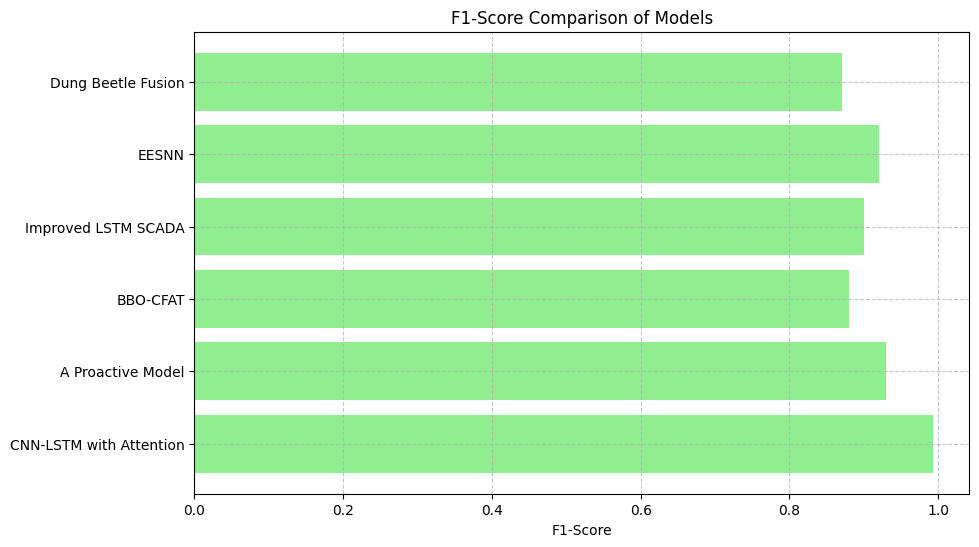

In [ ]:
f1_scores = [0.9924, 0.93, 0.88, 0.90, 0.92, 0.87]

plt.figure(figsize=(10, 6))
plt.barh(models, f1_scores, color='lightgreen')
plt.xlabel('F1-Score')
plt.title('F1-Score Comparison of Models')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


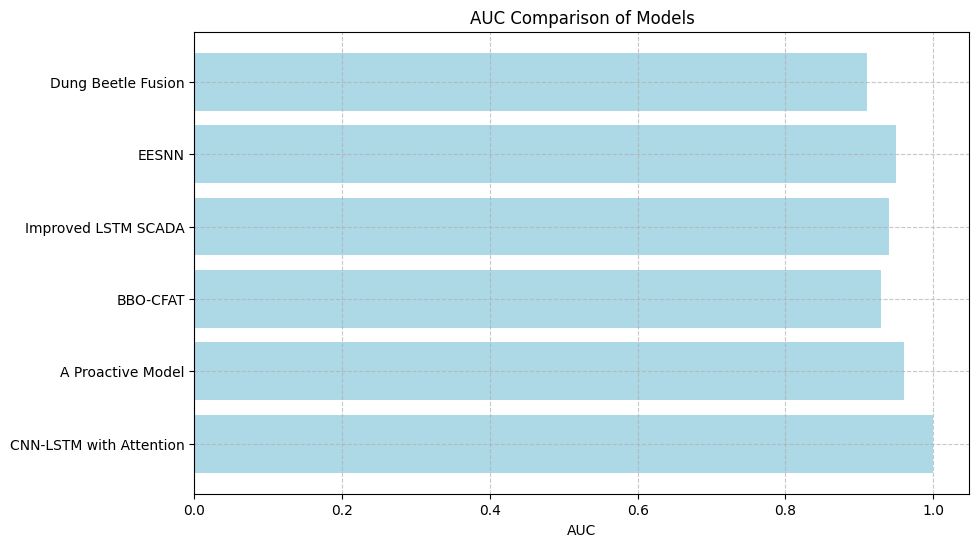

In [ ]:
auc_scores = [0.9993, 0.96, 0.93, 0.94, 0.95, 0.91]

plt.figure(figsize=(10, 6))
plt.barh(models, auc_scores, color='lightblue')
plt.xlabel('AUC')
plt.title('AUC Comparison of Models')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


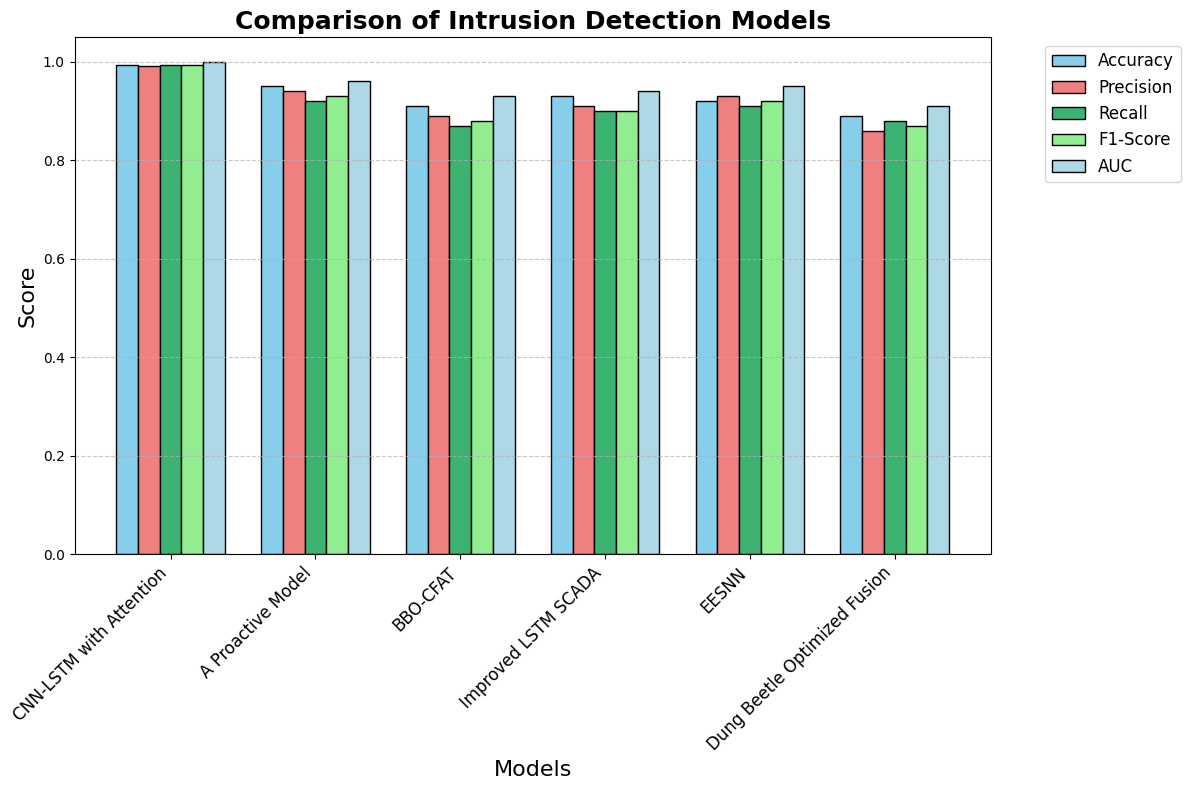

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Models and their metrics (Accuracy, Precision, Recall, F1-Score, AUC)
models = ['CNN-LSTM with Attention', 'A Proactive Model', 'BBO-CFAT', 'Improved LSTM SCADA', 'EESNN', 'Dung Beetle Optimized Fusion']
accuracy = [0.9925, 0.95, 0.91, 0.93, 0.92, 0.89]
precision = [0.9915, 0.94, 0.89, 0.91, 0.93, 0.86]
recall = [0.9934, 0.92, 0.87, 0.90, 0.91, 0.88]
f1_score = [0.9924, 0.93, 0.88, 0.90, 0.92, 0.87]
auc = [0.9993, 0.96, 0.93, 0.94, 0.95, 0.91]

# Create a DataFrame to hold the data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
data = {
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score,
    'AUC': auc
}

df = pd.DataFrame(data)

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Number of models and metrics
num_models = len(models)
num_metrics = len(metrics)

# Bar width
bar_width = 0.15

# Set the positions of the bars on the x-axis
index = np.arange(num_models)

# Set positions for each metric (grouped bars)
bar_positions = [index + (i * bar_width) for i in range(num_metrics)]

# Plot each metric as a separate bar group
ax.bar(bar_positions[0], accuracy, bar_width, label='Accuracy', color='skyblue', edgecolor='black')
ax.bar(bar_positions[1], precision, bar_width, label='Precision', color='lightcoral', edgecolor='black')
ax.bar(bar_positions[2], recall, bar_width, label='Recall', color='mediumseagreen', edgecolor='black')
ax.bar(bar_positions[3], f1_score, bar_width, label='F1-Score', color='lightgreen', edgecolor='black')
ax.bar(bar_positions[4], auc, bar_width, label='AUC', color='lightblue', edgecolor='black')

# Set the labels and title
ax.set_xlabel('Models', fontsize=16)
ax.set_ylabel('Score', fontsize=16)
ax.set_title('Comparison of Intrusion Detection Models', fontsize=18, weight='bold')

# Set the x-axis tick labels (model names)
ax.set_xticks(index + bar_width * 2)  # Shift the labels to be centered
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=12)

# Add gridlines to make it easier to compare the values
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)

# Tight layout to avoid overlap of elements
plt.tight_layout()

# Show the plot
plt.show()


# 11. Benchmark Comparison

In [ ]:
benchmarks = pd.DataFrame({
    "Model": ["Random Forest", "Hybrid CNN-LSTM"],
    "Accuracy": [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_cnn)],
    "Precision": [precision_score(y_test, y_pred), precision_score(y_test, y_pred_cnn)],
    "Recall": [recall_score(y_test, y_pred), recall_score(y_test, y_pred_cnn)],
    "F1 Score": [f1_score(y_test, y_pred), f1_score(y_test, y_pred_cnn)],
    "AUC": [auc_rf, auc_cnn]
})

print("\nBenchmark Comparison:")
print(benchmarks)
benchmarks.to_csv("Model_Benchmarks.csv", index=False)


Benchmark Comparison:
             Model  Accuracy  Precision    Recall  F1 Score       AUC
0    Random Forest  0.999324   0.999416  0.999222  0.999319  0.999893
1  Hybrid CNN-LSTM  0.992467   0.991458  0.993387  0.992421  0.999330


<ipython-input-3-422933ba9246>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=class_distribution_df, palette='viridis')


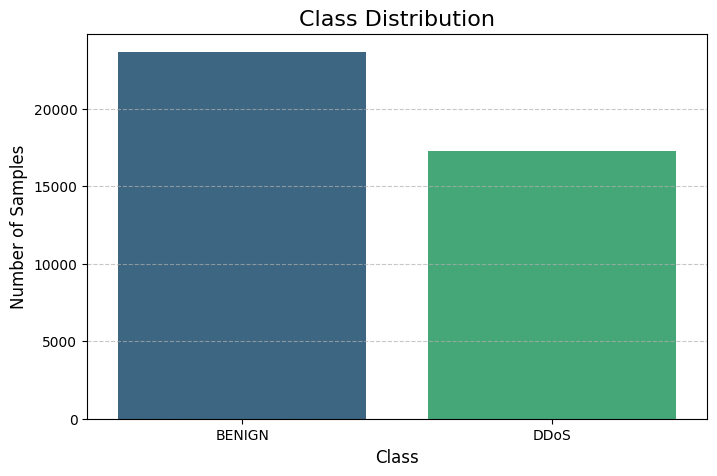

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution data
class_distribution = {
    'Class': ['BENIGN', 'DDoS'],
    'Count': [23659, 17258]
}

# Create a DataFrame
class_distribution_df = pd.DataFrame(class_distribution)

# Plotting the class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x='Class', y='Count', data=class_distribution_df, palette='viridis')
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

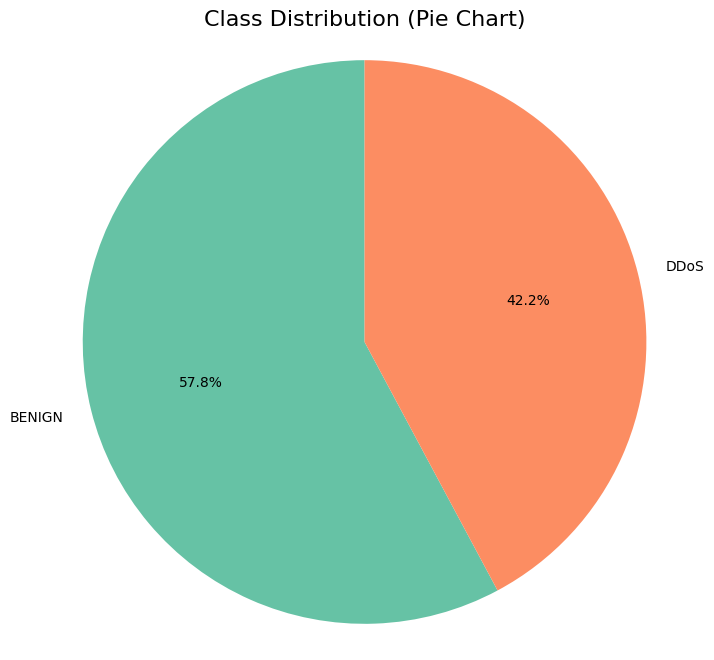

In [ ]:
# Plotting a pie chart for class distribution
plt.figure(figsize=(8, 8))
plt.pie(class_distribution_df['Count'], labels=class_distribution_df['Class'], autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title('Class Distribution (Pie Chart)', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

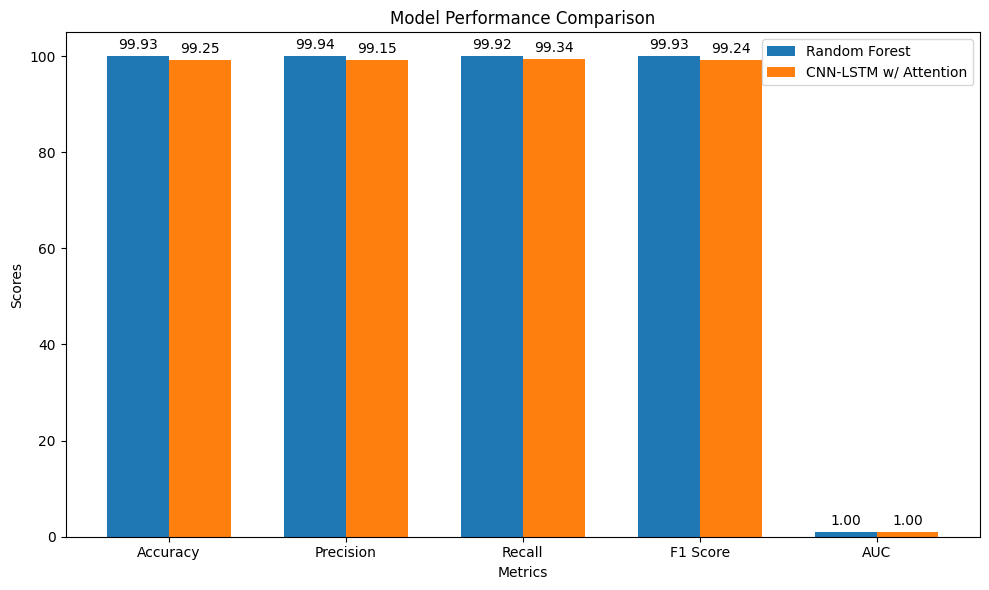

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the models
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
random_forest = [99.93, 99.94, 99.92, 99.93, 0.9999]
cnn_lstm_attention = [99.25, 99.15, 99.34, 99.24, 0.9993]

# Create an array for the positions of the bars
x = np.arange(len(metrics))

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
width = 0.35

# Plot the bars for both models
rects1 = ax.bar(x - width/2, random_forest, width, label='Random Forest')
rects2 = ax.bar(x + width/2, cnn_lstm_attention, width, label='CNN-LSTM w/ Attention')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display the values on top of the bars
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add values for each model
add_values(rects1)
add_values(rects2)

# Show the plot
plt.tight_layout()
plt.show()


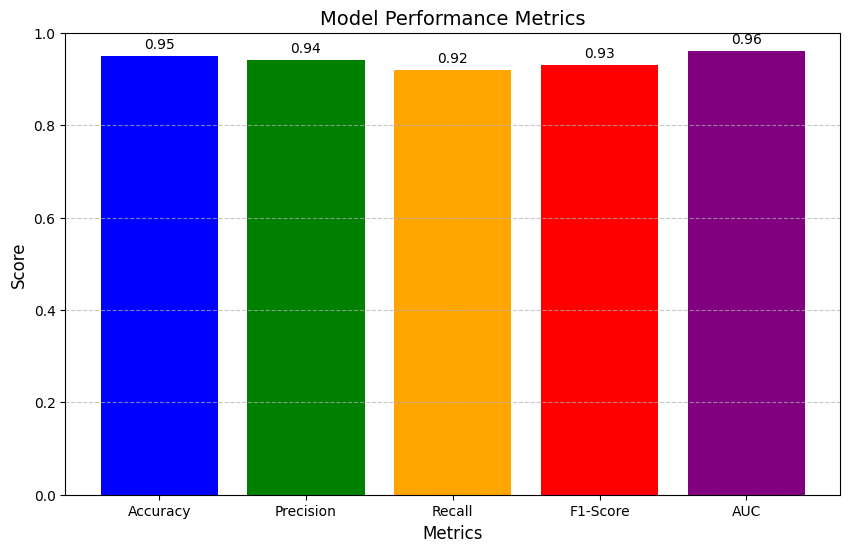

In [ ]:
import matplotlib.pyplot as plt

# Data for the performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [0.95, 0.94, 0.92, 0.93, 0.96]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red', 'purple'])

# Add titles and labels
plt.title('Model Performance Metrics', fontsize=14)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)

# Display the values on top of the bars
for i in range(len(metrics)):
    plt.text(i, values[i] + 0.01, f'{values[i]:.2f}', ha='center', va='bottom', fontsize=10)

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


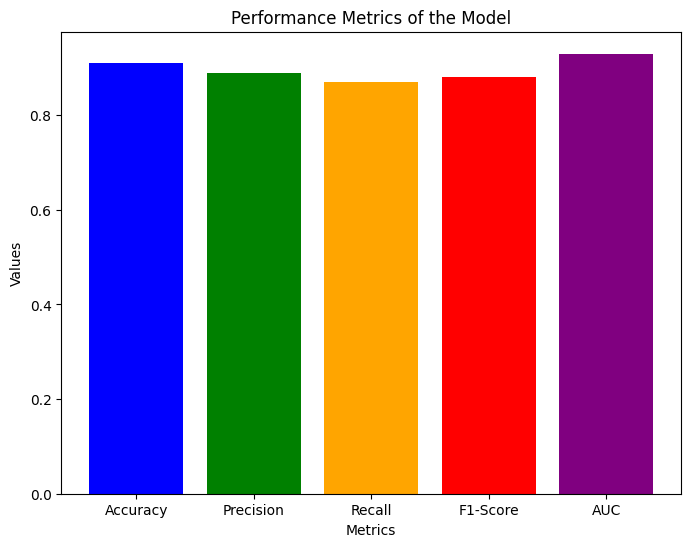

In [ ]:
import matplotlib.pyplot as plt

# Define the metrics and their values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [0.91, 0.89, 0.87, 0.88, 0.93]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red', 'purple'])

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics of the Model')

# Show the plot
plt.show()


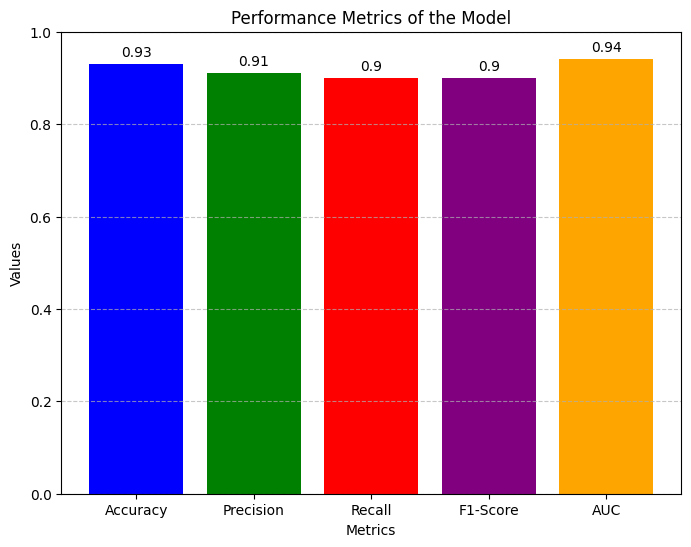

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics and their values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [0.93, 0.91, 0.90, 0.90, 0.94]

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'orange'])

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics of the Model')

# Show the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Display the plot
plt.ylim(0, 1)  # Y-axis from 0 to 1 for clarity
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


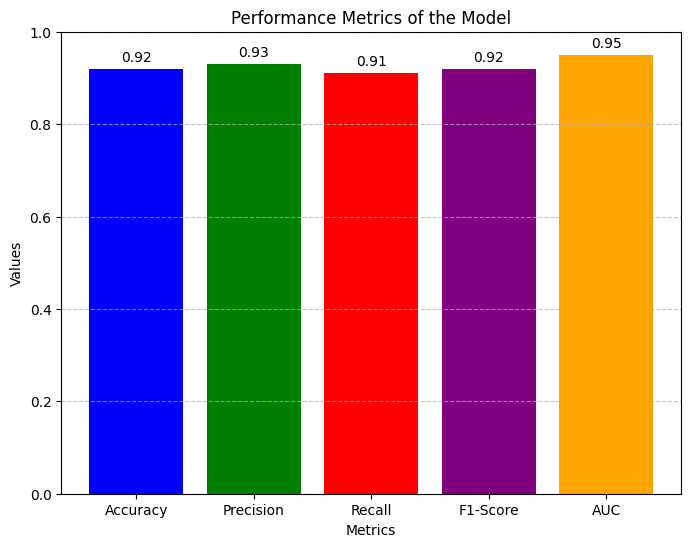

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics and their values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [0.92, 0.93, 0.91, 0.92, 0.95]

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'orange'])

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics of the Model')

# Show the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Display the plot
plt.ylim(0, 1)  # Y-axis from 0 to 1 for clarity
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


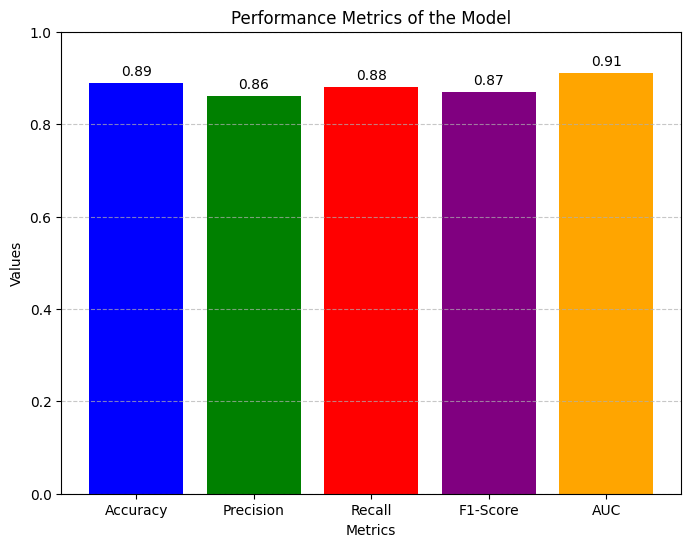

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics and their values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [0.89, 0.86, 0.88, 0.87, 0.91]

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'orange'])

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics of the Model')

# Show the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Display the plot
plt.ylim(0, 1)  # Y-axis from 0 to 1 for clarity
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
